<a href="https://colab.research.google.com/github/Ryan0v0/nninn/blob/master/vq_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip3 install -U -r requirements.txt

# Step1: Splitting up neural net params into chunks

In [ ]:
import torch
import torch.nn as nn

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(10, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = NeuralNetwork()

# Split up the neural network parameters into chunks
chunk_size = 1000
param_chunks = []
for param in net.parameters():
    flattened_param = param.view(-1)
    chunks = torch.split(flattened_param, chunk_size)
    param_chunks.extend(chunks)

# Print the number of parameter chunks
print("Number of parameter chunks:", len(param_chunks))
print("Parameter chunks:", param_chunks)


Number of parameter chunks: 15
Parameter chunks: [tensor([ 0.1222,  0.1068,  0.2057, -0.0562, -0.3046,  0.2264, -0.2255,  0.0539,
        -0.0720, -0.2888,  0.2038,  0.2844, -0.0784, -0.1794, -0.2697, -0.2333,
         0.2155, -0.2244,  0.0991, -0.2028, -0.0064,  0.2146,  0.2932, -0.2921,
        -0.1681,  0.2272,  0.1859, -0.1806,  0.0093, -0.0442, -0.0142, -0.0729,
         0.0670, -0.1173,  0.1280, -0.2975,  0.3126,  0.3093,  0.0792,  0.1557,
         0.2611, -0.0594, -0.1504,  0.1646, -0.2422,  0.0476, -0.0771, -0.2984,
        -0.1154,  0.0286, -0.0134,  0.1182, -0.2198, -0.1809, -0.0868, -0.0245,
        -0.1141, -0.1783, -0.0108,  0.2446, -0.2347,  0.2590,  0.1743,  0.1418,
         0.2000,  0.2493,  0.2277,  0.0690, -0.2095,  0.1163, -0.1702, -0.1447,
         0.0441,  0.3034,  0.1514, -0.1676, -0.2470, -0.2150, -0.1889,  0.0420,
        -0.2927, -0.2946, -0.2869,  0.0575, -0.2357,  0.2420, -0.0663, -0.0805,
        -0.2156,  0.0286,  0.2138,  0.0369, -0.2989,  0.0021, -0.2125,

In [ ]:
import numpy as np

# Convert param_chunks to a numpy array
param_chunks_np = np.concatenate([chunk.detach().numpy() for chunk in param_chunks])

print(type(param_chunks_np))
print("size:", param_chunks_np.shape)

<class 'numpy.ndarray'>
size: (11301,)


# Step2: learning a mapping from each chunk to an integer via VQ-VAE

In [ ]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

# import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

To verify the correctness of the VQVAE itself, I am currently using CIFAR-10 as input data.

Next step: using the weights of the above neural network as input.

In [ ]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(training_data.data[0])
print("size:", training_data.data.shape)
print(validation_data.data[0])
print("size:", validation_data.data.shape)

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
size: (50000, 32, 32, 3)
[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 

In [ ]:
data_variance = np.var(training_data.data / 255.0)

In [ ]:
data_variance = np.var(param_chunks_np / 255.0)

print(data_variance)

9.693462e-08


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        '''
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        '''
        # convert inputs from HW -> HW
        inputs = inputs.permute(0, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 1).contiguous(), perplexity, encodings # (0, 3, 1, 2)

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 1).contiguous() # (0, 2, 3, 1)
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 1).contiguous(), perplexity, encodings # (0, 3, 1, 2)

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._linear_1 = nn.Linear(in_channels*64, num_hiddens//2)
        self._linear_2 = nn.Linear(num_hiddens//2, num_hiddens)

    def forward(self, inputs):
        x = self._linear_1(inputs.view(inputs.size(0), -1)) # x = self._linear_1(inputs)
        x = F.relu(x)
        x = self._linear_2(x)
        x = F.relu(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._linear_1 = nn.Linear(in_channels, num_hiddens)
        self._linear_2 = nn.Linear(num_hiddens, num_hiddens//2)

    def forward(self, inputs):
        x = self._linear_1(inputs.view(inputs.size(0), -1)) # x = self._linear_1(inputs)
        x = F.relu(x)
        x = self._linear_2(x)
        x = F.relu(x)
        return x

## Train

We use the hyperparameters from the author's code:

In [ ]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset from param_chunks_np
dataset = TensorDataset(torch.from_numpy(param_chunks_np))

# Set the batch size and other DataLoader parameters
batch_size = 64
shuffle = True
pin_memory = True

# Create the DataLoader using the custom dataset
training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

print(training_loader)

print(iter(training_loader))

data = next(iter(training_loader))

print("ori_data=", data)

print(type(next(iter(training_loader))))
# print(data[0])

data = next(iter(training_loader))
# for i in range(len(data)):
#    data[i] = data[i].to(device)
data = torch.stack(data).to(device)
print("data=", data)

# There's no label in the NN weight dataset
'''
for batch_idx, data in enumerate(training_loader):
    print("Batch Index:", batch_idx)
    print("Data:", data)
    print()
'''

ori_data= [tensor([-0.0396, -0.0665, -0.0877, -0.0318, -0.0004, -0.0822,  0.0872, -0.0917,
         0.0553,  0.0500, -0.0420, -0.0719,  0.2505, -0.0344,  0.0437,  0.0262,
         0.0531, -0.0836, -0.0333, -0.0235,  0.0504, -0.0576,  0.3122, -0.0788,
         0.0245, -0.0302,  0.0814,  0.0623, -0.0601,  0.0100,  0.0962, -0.0312,
        -0.0032,  0.0447,  0.0414, -0.0146,  0.0325, -0.2088,  0.0920, -0.0512,
         0.0291, -0.0869,  0.0963, -0.0923,  0.0911,  0.0613,  0.0603,  0.0449,
         0.0657, -0.0218, -0.0213, -0.0973,  0.0433,  0.0882,  0.0441, -0.0382,
         0.2272, -0.0548,  0.0101, -0.0588, -0.0692,  0.0296,  0.0986, -0.0450])]
<class 'list'>
data= tensor([[ 0.0623, -0.0420,  0.0717,  0.0400,  0.0049, -0.0723,  0.0753,  0.0917,
         -0.0923, -0.0101,  0.0693,  0.0112,  0.0922, -0.0650,  0.0778,  0.0735,
         -0.0104, -0.0219, -0.0213, -0.0863, -0.0918,  0.0246,  0.0290, -0.0087,
          0.0370, -0.0071,  0.0386,  0.0498, -0.0182,  0.0277, -0.0713, -0.2578,
  

'\nfor batch_idx, data in enumerate(training_loader):\n    print("Batch Index:", batch_idx)\n    print("Data:", data)\n    print()\n'

In [ ]:
cifar_training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

cifar_training_loader = DataLoader(cifar_training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

print(cifar_training_loader)

print(iter(cifar_training_loader))

(data, _) = next(iter(cifar_training_loader))
print(type(next(iter(cifar_training_loader))))
print(type(data))
print(type(_))
print("ori_data=", data)

data = data.to(device)

print("data=", data)

'''
for batch_idx, (data, _) in enumerate(cifar_training_loader):
    print("Batch Index:", batch_idx)
    # print("Data:", data)
    print("Label:", _)
    print()
'''

Files already downloaded and verified
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
ori_data= tensor([[[[-0.2020, -0.1314, -0.1078,  ...,  0.1627,  0.1941,  0.1706],
          [-0.2412, -0.1863, -0.1549,  ...,  0.1157,  0.1863,  0.1980],
          [-0.2725, -0.2137, -0.1549,  ...,  0.0725,  0.1314,  0.1706],
          ...,
          [-0.1863, -0.1157,  0.0020,  ..., -0.2216, -0.2412, -0.2412],
          [-0.1745, -0.0608,  0.0412,  ..., -0.2412, -0.2529, -0.2529],
          [-0.1549, -0.0373,  0.0529,  ..., -0.2686, -0.2725, -0.2804]],

         [[-0.3078, -0.2333, -0.2020,  ...,  0.3157,  0.3510,  0.3235],
          [-0.3471, -0.2882, -0.2490,  ...,  0.2686,  0.3431,  0.3510],
          [-0.3745, -0.3078, -0.2412,  ...,  0.2216,  0.2843,  0.3235],
          ...,
          [-0.3392, -0.3039, -0.2255,  ..., -0.1431, -0.1510, -0.1431],
          [-0.3196, -0.2569, -0.1980,  ..., -0.1667, -0.1627, -0.1627],
          [-0.3000, -0.2451, -0.2020,  ..., -0.2020, -0.1941, -0.19

'\nfor batch_idx, (data, _) in enumerate(cifar_training_loader):\n    print("Batch Index:", batch_idx)\n    # print("Data:", data)\n    print("Label:", _)\n    print()\n'

In [ ]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        # Updated input size to [1, 64]
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

        # Replaced with nn.Linear
        self._pre_vq_linear = nn.Linear(num_hiddens, embedding_dim)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)


    def forward(self, x):
        # x = x.unsqueeze(0)  # Add an extra dimension for batch size
        ## print("x=", x)
        ## print(x.shape)
        z = self._encoder(x)
        z = z.view(z.size(0), -1)  # Flatten the tensor
        ## print("z0=", z)
        # Replaced self._pre_vq_conv with self._pre_vq_linear
        z = self._pre_vq_linear(z)
        ## print("z1=", z)

        loss, quantized, perplexity, _ = self._vq_vae(z)
        ## print("quantized:", quantized)

        # # Reshape quantized before passing it to the decoder
        # quantized = quantized.unsqueeze(2).unsqueeze(3)
        # print("quantized_after:", quantized)
        x_recon = self._decoder(quantized)

        # x_recon = 0
        return loss, x_recon, perplexity

In [ ]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    # (data, _) = next(iter(training_loader))
    # data = data.to(device)
    data = next(iter(training_loader))
    data = torch.stack(data).to(device)
    #for i in range(len(data)):
    #  data[i] = data[i].to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 31332172.474
perplexity: 1.000

200 iterations
recon_error: 66137.647
perplexity: 1.000

300 iterations
recon_error: 63640.532
perplexity: 1.000

400 iterations
recon_error: 64159.986
perplexity: 1.000

500 iterations
recon_error: 62112.338
perplexity: 1.000

600 iterations
recon_error: 63381.885
perplexity: 1.000

700 iterations
recon_error: 62301.385
perplexity: 1.000

800 iterations
recon_error: 66151.681
perplexity: 1.000

900 iterations
recon_error: 65254.224
perplexity: 1.000

1000 iterations
recon_error: 63407.027
perplexity: 1.000

1100 iterations
recon_error: 65560.906
perplexity: 1.000

1200 iterations
recon_error: 66131.750
perplexity: 1.000

1300 iterations
recon_error: 62130.387
perplexity: 1.000

1400 iterations
recon_error: 67442.499
perplexity: 1.000

1500 iterations
recon_error: 65572.944
perplexity: 1.000

1600 iterations
recon_error: 65659.319
perplexity: 1.000

1700 iterations
recon_error: 65136.998
perplexity: 1.000

1800 iterations
reco

## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

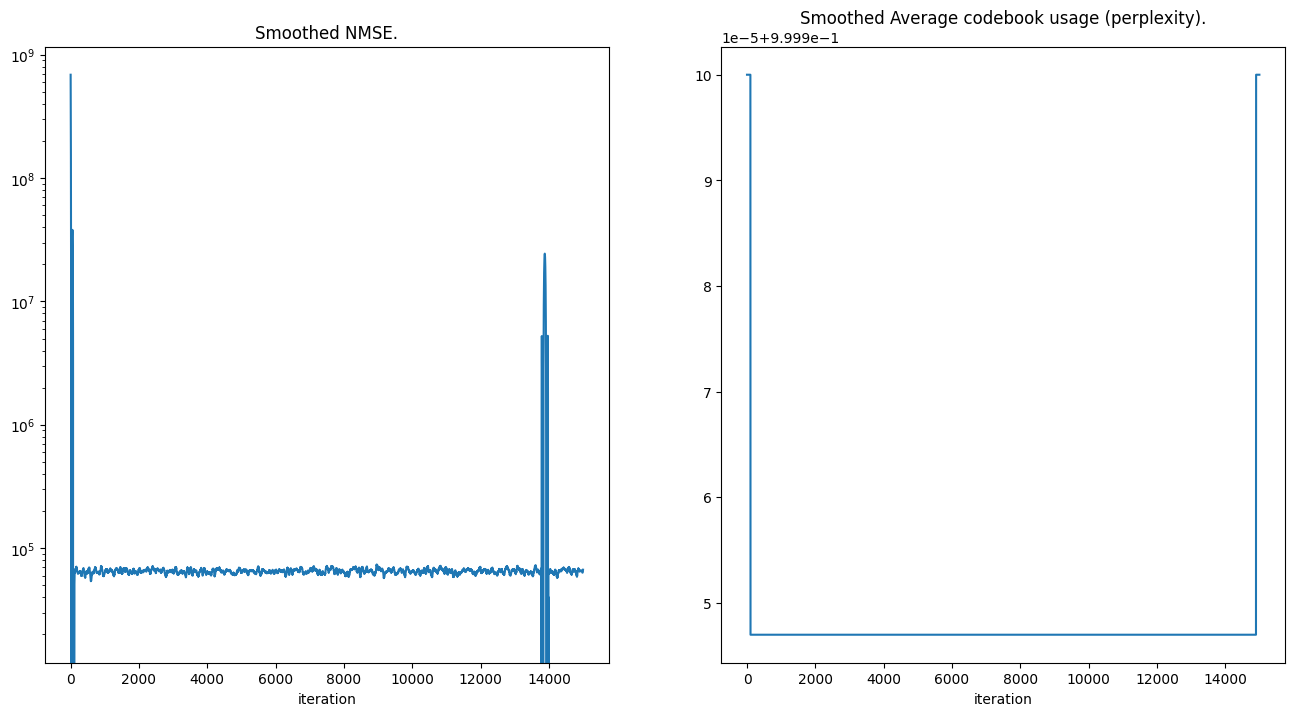

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)

ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [ ]:
model.eval()

data = next(iter(training_loader))
train_originals = torch.stack(data).to(device)
vq_output_eval = model._pre_vq_linear(model._encoder(train_originals))
print("vq_output_eval=", vq_output_eval)
print("vq_output_eval.shape=", vq_output_eval.shape)
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
print(valid_quantize)
print("valid_quantize=", valid_quantize)
print("valid_quantize.shape=", valid_quantize.shape)
# (train_originals, _) = next(iter(training_loader))
# train_originals = train_originals.to(device)
valid_reconstructions = model._decoder(valid_quantize)

vq_output_eval= tensor([[-1884.9658,  2048.9319,  2725.9292,  1245.3231, -1547.4535, -3653.6519,
          3015.4346, -2897.9211,  1842.8062, -1727.8453,  1921.6335, -2888.3286,
         -1738.5059, -2552.2874, -2701.4187, -3007.8386,  2787.1882,  3709.6914,
          1029.8738,  2732.1780, -3377.9255,  1488.0131,  1887.6740,  3660.0315,
         -3916.1221, -1208.9628,  3557.1924,  -916.0091,  1474.8965, -3495.5505,
         -2308.5015, -3433.2634,  3088.6602, -2499.3630,  3429.8611, -2718.6707,
          2977.5635, -4192.2476,  1567.3772,  3105.5767,  3341.0271,  2037.2435,
         -3651.0935,  2101.8682, -4034.9668,  3295.6282,  1524.3365,  1497.4159,
         -3537.7490,  3236.4468, -3334.4500, -3545.3523,  1981.4486,  2674.2563,
         -3133.9414,  2795.5120,  1826.0248,  4481.3979,  2292.6943,  2255.3096,
          1235.6931,  3968.5437,  2786.0249,  1968.1360]],
       grad_fn=<AddmmBackward0>)
vq_output_eval.shape= torch.Size([1, 64])
tensor([[-2207.9583,  2402.3799,  3220.1

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(train_originals.cpu()+0.5))

## View Embedding

In [ ]:
! pip uninstall umap
! pip install umap-learn

import umap.umap_ as umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

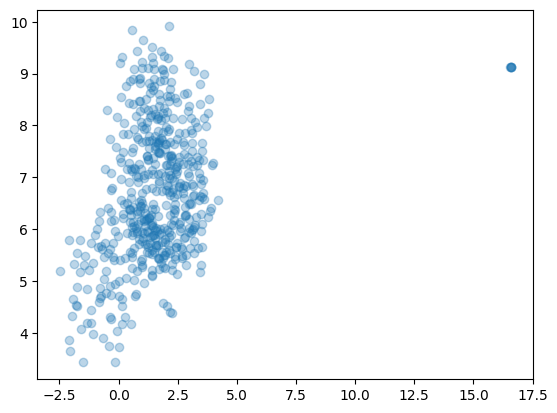

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)